In [1]:
# confir job id, to see you are on compute node
!echo $LSB_JOBID

148001002


In [2]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr
import pandas as pd

import napari, qtpy, superqt
print("napari:", napari.__version__)
print("qtpy:", qtpy.__version__)
print("superqt:", superqt.__version__)

napari: 0.6.4
qtpy: 2.4.3
superqt: 0.7.6


In [3]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [4]:
%gui qt
%config Completer.use_jedi = False  #magic to fix autocomplete issue

# viewer

QStandardPaths: error creating runtime directory '/run/user/65875' (Permission denied)
QStandardPaths: error creating runtime directory '/run/user/65875' (Permission denied)
Qt: Session management error: Could not open network socket


In [5]:
from fly2p.viz.viz import *
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume
onCluster = True

### data details

In [6]:
# === Set root storage directory depending on environment ===
storageDir = '/groups/otopalik' if onCluster else '/Volumes'
# rootDir = '/Volumes/otopaliklab/Temporary_Storage/Aisha/ImagingData'
# rootDir = 'C:\\Users\\hamida\\Documents\\Data'
rootDir = '/groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData'

In [7]:
flyID = 'Fly_0013'
trial_folder = 'E'


dataDir = sep.join([rootDir, 'raw', flyID, trial_folder])
preprocDir = sep.join([rootDir, 'preproc', flyID, trial_folder])
plotDir = sep.join([rootDir, 'plot',flyID, trial_folder])

# Create the directories if they don't exist
os.makedirs(dataDir, exist_ok=True)
os.makedirs(preprocDir, exist_ok=True)
os.makedirs(plotDir, exist_ok=True)


print(f'flyID: {flyID}, trial folder: {trial_folder}')
rawTiff = 'Fly_0013E_00001.tif'


flyID: Fly_0013, trial folder: E


In [8]:
tiff_path = sep.join([dataDir, rawTiff])
tiff_path

'/groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/raw/Fly_0013/E/Fly_0013E_00001.tif'

In [9]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
SImetadict = getSIMetadict(mytiffreader.metadata())

SI.VERSION_COMMIT = 'b0e89ff7717e60826b56173afe65ddb1ea6efb87'
SI.VERSION_MAJOR = 2023
SI.VERSION_MINOR = 1
SI.VERSION_UPDATE = 0


In [10]:
basicMetadat["CaCh"] = 0 # give channel identity
# Load data: With larger file sizes, the scanimage loader fails (idk why)
stack = loadvolume(tiff_path, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

In [11]:
basicMetadat

{'nCh': 1,
 'fpsscan': 85.42214285714286,
 'discardFBFrames': 'false',
 'nDiscardFBFrames': 0,
 'fpv': 9,
 'nVols': 2350,
 'stackZStepSize': 5.0,
 'scanVolumeRate': 9.491349206349206,
 'fovCoords': {'p00': [np.float64(-67.50000000000001),
   np.float64(-67.50000000000001)],
  'p10': [np.float64(67.50000000000001), np.float64(67.50000000000001)],
  'p01': [np.float64(67.50000000000001), np.float64(-67.50000000000001)],
  'p11': [np.float64(-67.50000000000001), np.float64(67.50000000000001)]},
 'xrange_um': np.float64(135.00000000000003),
 'yrange_um': np.float64(135.00000000000003),
 'CaCh': 0}

In [12]:
imgStack.shape

(2350, 9, 256, 256)

### motion correction

/tmp/ipykernel_410387/374984881.py:11: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


Figure saved to: /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_0013/E/motion_correction_reference image.png


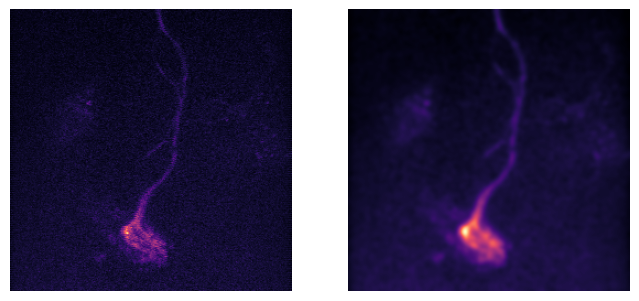

In [13]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over planes

numRefImg = 20
refstart = 100
locRefImg = round(stackMP['volumes [s]'].size/2)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0) + np.mean(stackMP[refstart:refstart+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='magma', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='magma', origin='lower'); axs[1].axis('off');


# Save figure
save_path = os.path.join(preprocDir, 'motion_correction_reference image.png')
fig.savefig(save_path, bbox_inches='tight', dpi=300)
print(f"Figure saved to: {save_path}")


In [ ]:
# use this if you want to construct a ref image (for MC) just based on the average across volumes
# ref_Img_avg = np.mean(stackMP,axis=0)

In [14]:
stackMP.shape

(2350, 256, 256)

In [15]:
stackMP_fraction = stackMP[:32600]
stackMP_fraction.shape

(2350, 256, 256)

In [16]:
stackMP2 = stackMP_fraction

perform motion correction on a single plane/max projection
. . . . . . . . . . . . . . . . . . . . Figure saved to: /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_0013/E/motion_correction_shifts_x_y.png


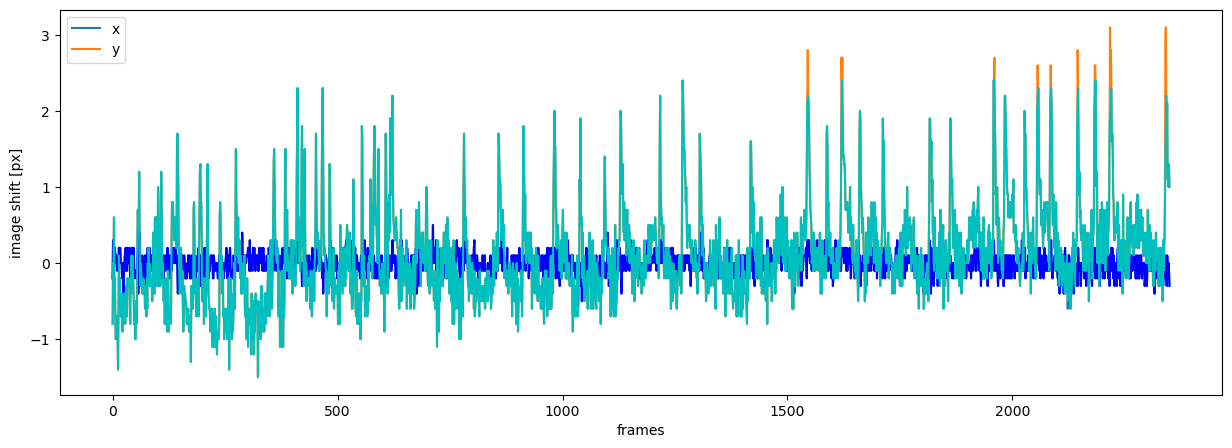

In [17]:
# If there are unreasonable shifts select "doFilter=True".

shift = imp.computeMotionShift(stackMP2, refImg, 10, 2, doFilter=True, stdFactor=4, showShiftFig=True)
stackMPMC = imp.motionCorrection(stackMP2, shift)

# Save figure
save_path = os.path.join(preprocDir, 'motion_correction_shifts_x_y.png')
fig.savefig(save_path, bbox_inches='tight', dpi=300)
print(f"Figure saved to: {save_path}")

In [18]:
stackMPMC.shape

(2350, 256, 256)

In [19]:
# To visualize all your volumes
viewer = napari.view_image(stackMPMC)
viewer.window._qt_window.raise_()
viewer.window._qt_window.activateWindow()
viewer.window._qt_window.show()

/tmp/ipykernel_3951449/184108534.py:2: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  viewer = napari.view_image(stackMPMC)


In [20]:
viewer.close()

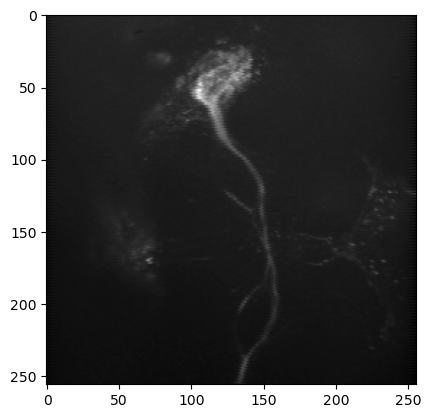

In [21]:
plt.imshow(np.mean(stackMPMC,axis=0), cmap='Greys_r')

Figure saved to: /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_0013/E/motion_correction_comparison.png


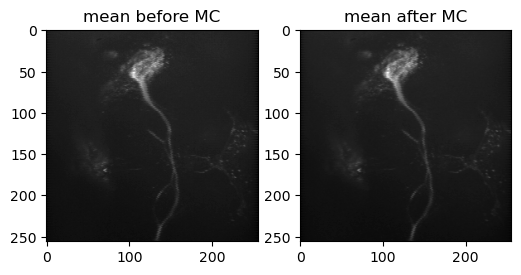

In [22]:
fig,axs = plt.subplots(1,2, figsize=(6,4))

axs[0].imshow(np.mean(stackMP2,axis=0),cmap='Greys_r')
axs[0].set_title('mean before MC')
axs[1].imshow(np.mean(stackMPMC,axis=0), cmap='Greys_r')
axs[1].set_title('mean after MC')


# Save figure
save_path = os.path.join(preprocDir, 'motion_correction_comparison.png')
fig.savefig(save_path, bbox_inches='tight', dpi=300)
print(f"Figure saved to: {save_path}")



Variance map saved to: /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_0013/E/temporal_variance_map.png


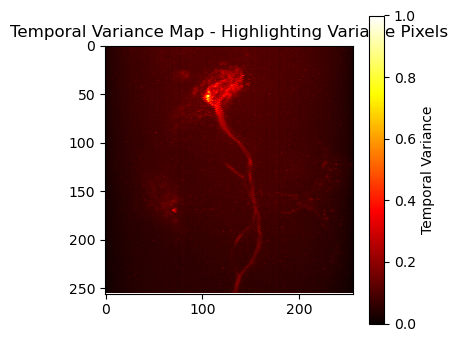

In [35]:
# variance image, ref to choose regions of interest:

# stackMPMC: shape (time, x, y) → (6652, 256, 256)
# Example for xarray:
var_image = stackMPMC.var(dim='volumes [s]')  # variance across time
var_np = var_image.values

# Normalize for display
var_norm = (var_np - var_np.min()) / (var_np.max() - var_np.min() + 1e-8)

plt.figure(figsize=(4, 4))
plt.imshow(var_norm, cmap='hot')
plt.colorbar(label='Temporal Variance')
plt.title('Temporal Variance Map - Highlighting Variable Pixels')

# Save before showing
save_path = os.path.join(preprocDir, 'temporal_variance_map.png')
plt.savefig(save_path, bbox_inches='tight', dpi=300)
print(f"Variance map saved to: {save_path}")

plt.show()

In [36]:
stackMPMC.shape

(2350, 256, 256)

In [58]:
# defining rois:
mean_proj_in_time_stackMPMC = np.mean(stackMPMC, axis=0)
# ------------------------------------------
# Open Napari and draw ROI mask
# ------------------------------------------
viewer = napari.view_image(mean_proj_in_time_stackMPMC.values
        , contrast_limits=[mean_proj_in_time_stackMPMC.values.min(),np.percentile(mean_proj_in_time_stackMPMC.values, 99.9)]
        , name='mean_stackMPMC'
        , colormap='gray'
)
# if exists(sep.join([preprocDir,'mask_2d.npy'])):
#     mask = np.load(sep.join([preprocDir,'mask_2d.npy'])) 
#     viewer.add_labels(mask, opacity=0.2)
#     print('exists')

/tmp/ipykernel_3951449/3350386338.py:6: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  viewer = napari.view_image(mean_proj_in_time_stackMPMC.values


In [ ]:
#viewer.close()

In [59]:
# ------------------------------------------
# Retrieve mask and close viewer for EB analysis
# ------------------------------------------
mask_layer = viewer.layers["mask"] 

if mask_layer is None:
    raise ValueError("No mask layer named 'mask' was found in Napari.")
mask_data = mask_layer.data
viewer.close()

# ------------------------------------------
# Save mask as .npy
# ------------------------------------------
save_dir = os.path.join(preprocDir)
os.makedirs(save_dir, exist_ok=True)
mask_path = os.path.join(save_dir, 'mask_2d.npy')
np.save(mask_path,mask_data)
print(f"ROI mask saved to: {mask_path}")

ROI mask saved to: /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_0013/E/mask_2d.npy


/tmp/ipykernel_3951449/2226417715.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Reds', len(roi_labels))


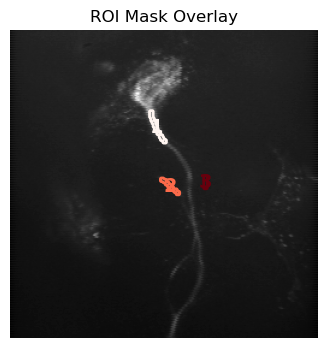

In [60]:
from matplotlib import cm
# ------------------------------------------
# Plot base anatomy with ROI contours & labels
# ------------------------------------------

# Normalize base image for good contrast
base_image = mean_proj_in_time_stackMPMC
base_image_norm = (base_image - base_image.min()) / (base_image.max() - base_image.min() + 1e-8)

# Extract ROI labels
roi_labels = np.unique(mask_data)
roi_labels = roi_labels[roi_labels > 0]  # Exclude background

# Colormap for contours
colors = cm.get_cmap('Reds', len(roi_labels))
#colors = [cm.get_cmap('Reds')(i) for i in np.linspace(0.2, 0.9, len(roi_labels))]

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(base_image_norm, cmap='Greys_r', origin='upper')

# Draw ROI contours and labels
for i, roi in enumerate(roi_labels):
    mask_outline = np.zeros_like(mask_data)
    mask_outline[mask_data == roi] = 1
    ax.contour(mask_outline, levels=[0.5], colors=[colors(i)], linewidths=2)
    
    coords = np.argwhere(mask_data == roi)
    centroid = coords.mean(axis=0)
    ax.text(
        centroid[1], centroid[0], str(int(roi)),
        color=colors(i), fontsize=14, fontweight='bold',
        ha='center', va='center'
    )

ax.set_title('ROI Mask Overlay')
ax.axis('off')

# Save as PNG with high DPI
save_path = os.path.join(save_dir, 'mask_2d_overlay.png')
fig.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

# print(f"Overlay figure saved to: {overlay_path}")

In [61]:
# plot raw average fluorescence:
# -----------------------------
# Load 2D labeled mask (H x W)
# -----------------------------
# mask_path = os.path.join(preprocDir, 'mask_2d.npy')
roi_mask = np.load(mask_path)  # values: 0 (bg), 1, 2, ...
# -----------------------------
# Initialize trace matrix
# -----------------------------
roi_labels = np.unique(roi_mask)
roi_labels = roi_labels[roi_labels > 0]  # exclude background
n_rois = len(roi_labels)
n_volumes = stackMPMC.shape[0]
roi_traces = np.zeros((n_rois, n_volumes), dtype=np.float32)
# -----------------------------
# Compute mean trace per ROI
# -----------------------------
for i, roi in enumerate(roi_labels):
    mask = (roi_mask == roi)
    masked_pixels = stackMPMC.values[:, mask]  # shape: (T, N_pixels)
    roi_traces[i] = masked_pixels.mean(axis=1)
print(f"Extracted {n_rois} ROI traces from {n_volumes} volumes.")

Extracted 3 ROI traces from 2350 volumes.


In [62]:
stackMPMC.shape

(2350, 256, 256)

Fluorescence trace figure saved to: /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/plot/Fly_0013/E/roi_raw_fluorescence_traces.png


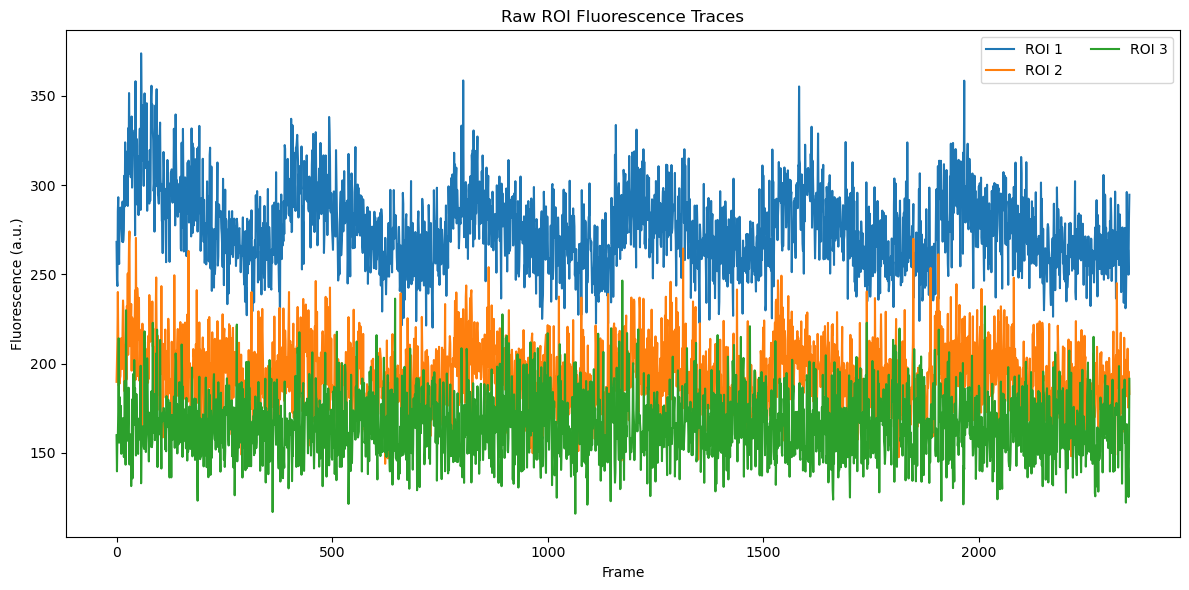

In [63]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(n_rois):
    ax.plot(roi_traces[i], label=f'ROI {roi_labels[i]}')

ax.set_xlabel('Frame')
ax.set_ylabel('Fluorescence (a.u.)')
ax.set_title('Raw ROI Fluorescence Traces')
ax.legend(loc='upper right', ncol=2)
plt.tight_layout()
# Save 
plot_path = os.path.join(plotDir, 'roi_raw_fluorescence_traces.png')
fig.savefig(plot_path, bbox_inches='tight', dpi=300)
print(f"Fluorescence trace figure saved to: {plot_path}")

plt.show()

In [64]:
method = 'percentile'
# baseline_window = 10  # Number of frames to use for baseline calculation
percentile_value = 10  # Percentile for baseline calculation if using 'percentile' method


n_rois, n_frames = roi_traces.shape
dff_traces = np.zeros_like(roi_traces, dtype=np.float32)

for i in range(n_rois):
    trace = roi_traces[i]
    if method == 'percentile':
        F0 = np.percentile(trace, percentile_value)
    elif method == 'mean':
        F0 = np.mean(trace[:baseline_window])
    else:
        raise ValueError("method must be 'percentile' or 'mean'")
    
    dff_traces[i] = (trace - F0) / F0

In [65]:
# print f0 value, shape to veriy
print("F0:", F0, "| shape:", np.shape(F0), "| type:", type(F0))

F0: 143.39394 | shape: () | type: <class 'numpy.float32'>


In [66]:
offset_option=False

/tmp/ipykernel_3951449/3510314375.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', n_rois)


Figure saved to: /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/plot/Fly_0013/E/roi_mask_and_dff_traces.png


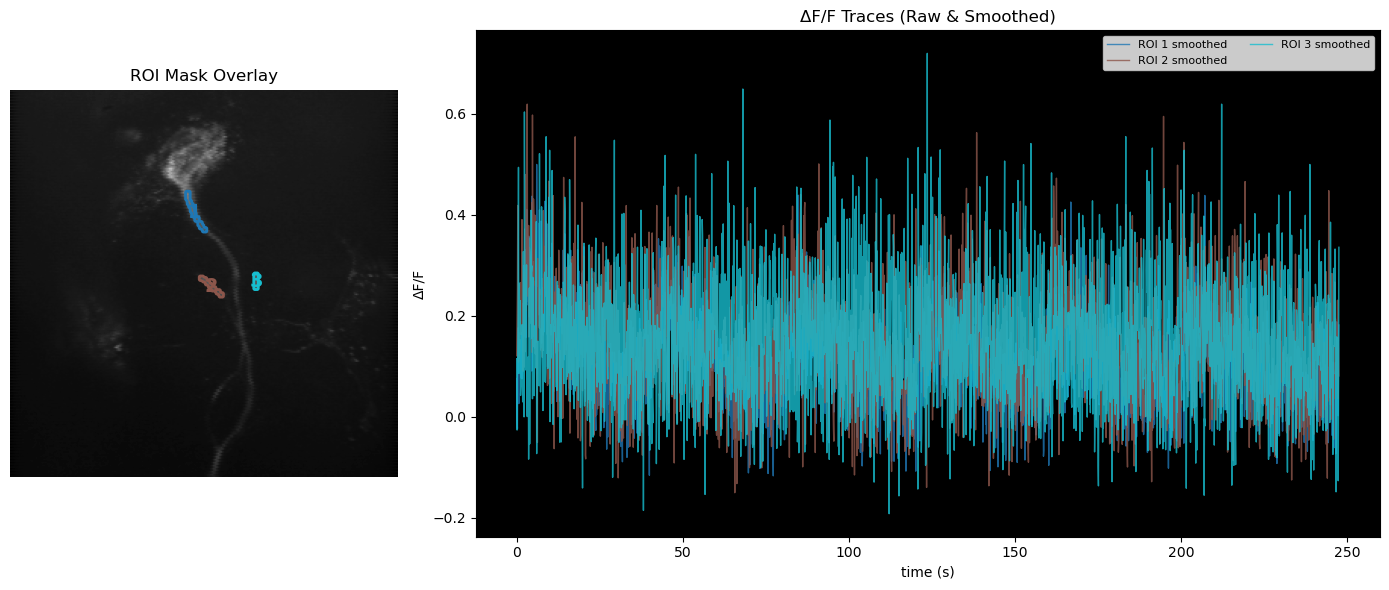

In [67]:
n_rois, n_frames = dff_traces.shape
colors = cm.get_cmap('tab10', n_rois)
volume_times = stackMPMC['volumes [s]'].values

# --------------------------
# Figure: Anatomy + ΔF/F traces
# --------------------------
fig, axes = plt.subplots(
    1, 2, figsize=(14, 6),
    gridspec_kw={'width_ratios': [0.3, 0.7]}
)

# --------------------------
# Subplot 1: ROI mask overlay on anatomy
# --------------------------
ax1 = axes[0]
ax1.imshow(mean_proj_in_time_stackMPMC, cmap='Greys_r', origin='upper')
ax1.imshow(mask_data, cmap='gray', alpha=0.25)  # faded base mask

# Overlay ROI contours and centroids
for i, roi in enumerate(roi_labels):
    coords = np.argwhere(mask_data == roi)
    centroid = coords.mean(axis=0)
    mask_outline = np.zeros_like(mask_data)
    mask_outline[mask_data == roi] = 1
    ax1.contour(mask_outline, levels=[0.5], colors=[colors(i)], linewidths=2)
    ax1.text(
        centroid[1], centroid[0], str(int(roi)),
        color=colors(i), fontsize=14, fontweight='bold',
        ha='center', va='center'
    )

ax1.set_title('ROI Mask Overlay')
ax1.axis('off')

# --------------------------
# Subplot 2: ΔF/F traces with smoothed overlay
# --------------------------
ax2 = axes[1]

if offset_option:
    offset = 1.5
    for i in range(n_rois):
        raw_trace = dff_traces[i]
        smooth_trace = dff_traces[i]
        color = colors(i)

        # Raw
        # ax2.plot(volume_times, raw_trace + i * offset,
        #          color=color, label=f'ROI {roi_labels[i]} raw', linewidth=1)

        # Smoothed
        ax2.plot(volume_times, smooth_trace + i * offset,
                 color=color, linestyle='-', linewidth=1, alpha=0.8,
                 label=f'ROI {roi_labels[i]} smoothed')

    ax2.set_yticks([i * offset for i in range(n_rois)])
    ax2.set_yticklabels([f'ROI {r}' for r in roi_labels])
    ax2.set_ylabel('ΔF/F + offset')

else:
    for i in range(n_rois):
        raw_trace = dff_traces[i]
        smooth_trace = dff_traces[i]
        color = colors(i) if n_rois > 1 else 'yellow'

        # Raw
        # ax2.plot(volume_times, raw_trace,
        #          label=f'ROI {roi_labels[i]} raw',
        #          color=color, linewidth=1)

        # Smoothed
        ax2.plot(volume_times, smooth_trace,
                 label=f'ROI {roi_labels[i]} smoothed',
                 color=color, linestyle='-', linewidth=1, alpha=0.8)

    ax2.set_ylabel('ΔF/F')

ax2.set_title('ΔF/F Traces (Raw & Smoothed)')
ax2.set_xlabel('time (s)')
# ax2.set_xlim([0, 75])  # adjust to your range
ax2.legend(loc='upper right', ncol=2, fontsize=8)
ax2.set_facecolor('black') # makes background black

plt.tight_layout()

# --------------------------
# Save the figure to plotDir
# --------------------------

plot_path = os.path.join(plotDir, 'roi_mask_and_dff_traces.png')
fig.savefig(plot_path, bbox_inches='tight', dpi=300)
print(f"Figure saved to: {plot_path}")

plt.show()

plt.show()

Figure saved to: /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/plot/Fly_0013/E/dff_traces_only.png


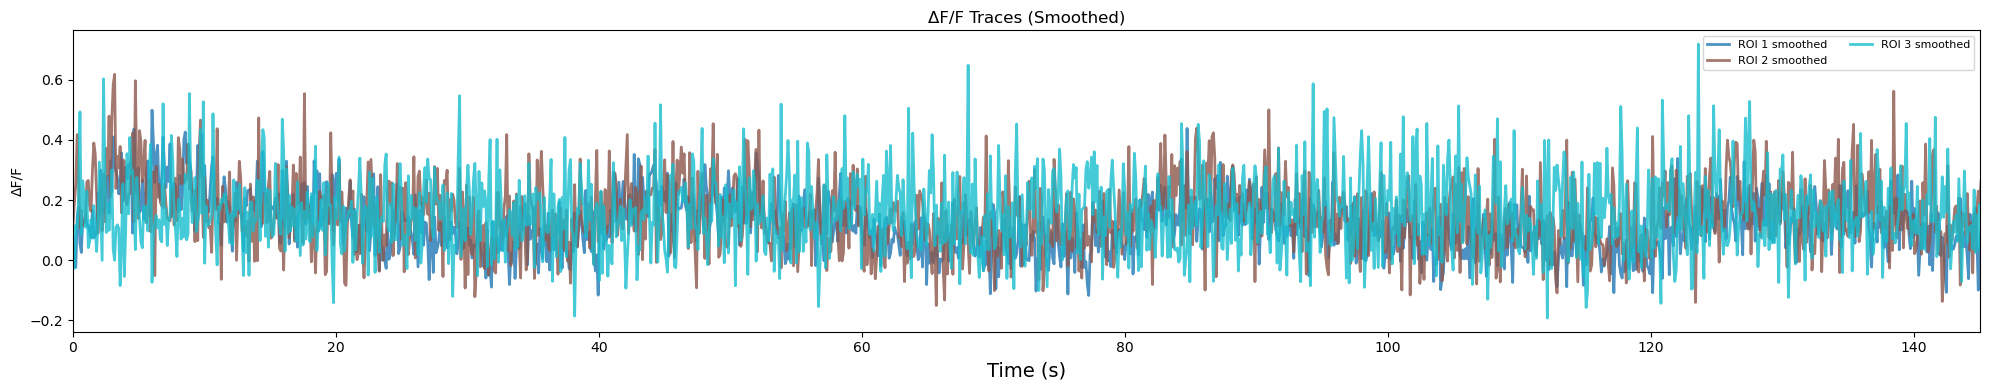

In [68]:
# --------------------------
# Figure: ΔF/F traces only
# --------------------------
fig, ax = plt.subplots(figsize=(20, 4))

if offset_option:
    offset = 1.5
    for i in range(n_rois):
        raw_trace = dff_traces[i]
        smooth_trace = dff_traces[i]
        color = colors(i)

        # Smoothed
        ax.plot(volume_times, smooth_trace + i * offset,
                color=color, linestyle='-', linewidth=2, alpha=0.8,
                label=f'ROI {roi_labels[i]} smoothed')

    ax.set_yticks([i * offset for i in range(n_rois)])
    ax.set_yticklabels([f'ROI {r}' for r in roi_labels])
    ax.set_ylabel('ΔF/F + offset', fontsize=14)

else:
    for i in range(n_rois):
        raw_trace = dff_traces[i]
        smooth_trace = dff_traces[i]
        color = colors(i) if n_rois > 1 else 'yellow'

        # Smoothed
        ax.plot(volume_times, smooth_trace,
                label=f'ROI {roi_labels[i]} smoothed',
                color=color, linestyle='-', linewidth=2, alpha=0.8)

    ax.set_ylabel('ΔF/F')

ax.set_title('ΔF/F Traces (Smoothed)')
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_xlim([0, 145])  # adjust to your range
ax.legend(loc='upper right', ncol=2, fontsize=8)
# ax.set_facecolor('black')  # Optional: black background

plt.tight_layout()

# --------------------------
# Save the figure to plotDir
# --------------------------
plot_path = os.path.join(plotDir, 'dff_traces_only.png')
fig.savefig(plot_path, bbox_inches='tight', dpi=300)
print(f"Figure saved to: {plot_path}")

# --------------------------
# Add shaded regions for LED ON periods
# --------------------------
led_on_duration = 5    # seconds
led_off_duration = 40  # seconds
cycle_duration = led_on_duration + led_off_duration

start_time = 0
end_time = volume_times[-1]  # total duration of time series

current_time = start_time
while current_time < end_time:
    led_on_start = current_time
    led_on_end = current_time + led_on_duration

    # # Shade LED ON region
    # ax.axvspan(led_on_start, led_on_end, color='red', alpha=0.3,
    #            label='LED ON' if current_time == 0 else None)  # label only once for legend

    current_time += cycle_duration
    
plt.show()


In [69]:
# --------------------------
# Create target subfolder
# --------------------------
img_dir = os.path.join(preprocDir, 'img')
os.makedirs(img_dir, exist_ok=True)

# --------------------------
# Save stackMPMC as .nc
# --------------------------
stack_path = os.path.join(img_dir, 'stackMPMC.nc')
stackMPMC.to_netcdf(stack_path)
print(f"Saved stackMPMC to {stack_path}")

# --------------------------
# Save raw dff_traces as CSV
# --------------------------
volume_times = stackMPMC['volumes [s]'].values  # shape: (T,)

roiDf_raw = pd.DataFrame(
    dff_traces.T,
    columns=[f'ROI_{r}' for r in roi_labels]
)
roiDf_raw.insert(0, 'volumes [s]', volume_times)

csv_path_raw = os.path.join(img_dir, 'raw_dff_traces.csv')
roiDf_raw.to_csv(csv_path_raw, index=False)
print(f"Saved raw ΔF/F traces to {csv_path_raw}")

# # --------------------------
# # Save smoothed dff_traces as CSV
# # --------------------------
# roiDf_smooth = pd.DataFrame(
#     dff_smoothed.T,
#     columns=[f'ROI_{r}' for r in roi_labels]
# )
# roiDf_smooth.insert(0, 'volumes [s]', volume_times)

# csv_path_smooth = os.path.join(img_dir, 'dff_traces_smoothed.csv')
# roiDf_smooth.to_csv(csv_path_smooth, index=False)
# print(f"Saved smoothed ΔF/F traces to {csv_path_smooth}")

# --------------------------
# Save metadata as JSON
# --------------------------
metadata_path = os.path.join(img_dir, 'imgMetadata.json')
with open(metadata_path, 'w') as f:
    json.dump(basicMetadat, f, indent=4)
print(f"Saved metadata to {metadata_path}")

Saved stackMPMC to /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_0013/E/img/stackMPMC.nc
Saved raw ΔF/F traces to /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_0013/E/img/raw_dff_traces.csv
Saved metadata to /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_0013/E/img/imgMetadata.json


In [70]:
# Save F0 as np array: 
F0_array = np.zeros(n_rois, dtype=np.float32)

for i in range(n_rois):
    trace = roi_traces[i]
    if method == 'percentile':
        F0 = np.percentile(trace, percentile_value)
    elif method == 'mean':
        F0 = np.mean(trace[:baseline_window])
    else:
        raise ValueError("method must be 'percentile' or 'mean'")
    
    F0_array[i] = F0
    dff_traces[i] = (trace - F0) / F0
    

f0_path = os.path.join(img_dir, 'F0_values.npy')
np.save(f0_path, F0_array)
print(f"Saved F0 values to {f0_path}")


Saved F0 values to /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_0013/E/img/F0_values.npy


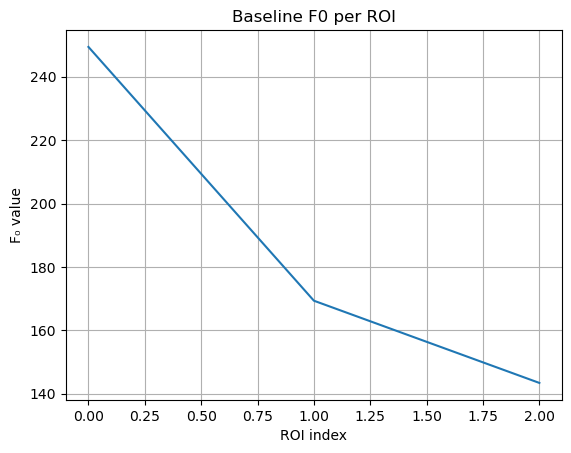

In [71]:
# Plot to visualize
plt.figure()
plt.plot(F0_array)
plt.xlabel('ROI index')
plt.ylabel('F₀ value')
plt.title('Baseline F0 per ROI')
plt.grid(True)
plt.show()

In [190]:
roiDf_raw.shape

(3850, 3)